# Answers

You can edit this Jupyter notebook to include your answers and run any code that generates those answers or produces plots.  You can add additional cells for code or markdown as needed.

This homework is primarily about running simulations involving initial value problems (IVPs) and a simple PDE.

In [12]:
!pip install sympy
!pip install numpy
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from scipy.integrate import DenseOutput
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.sparse as sparse
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols
from scipy.integrate import solve_ivp
import importlib

## Problem 0 (30 points)

In this problem, you will implement a custom ODE solver for `solve_ivp` based on the Forward Euler method, and implement some basic tests.

### Part A (20 points)
If you read the [documentation for `solve_ipv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), which we used in class, you'll see that you can write your own solver.

Write a solver for the forward Euler method, which is not implemented as one of the available solvers (while simple, it typically is not very accurate).  Recall, this is the basic rule:
\begin{equation}
y(t + h) = y(t) + h f(t, y)
\end{equation}

Your solver should be a class which is derived from [`scipy.integrate.OdeSolver`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.OdeSolver.html#scipy.integrate.OdeSolver)
```python
class ForwardEuler(scipy.integrate.OdeSolver):
    pass
```

Your class definition should go in [`euler.py`](euler.py)

You should read the documentation for this base class in order to implement `ForwardEuler`.  Here are some hints/notes:
* Allow a user to set `h` using a keyword argument.  This can be passed using `solve_ivp(..., method=ForwardEuler, h=0.01)` to set `h=0.01`
* Use a default step size `h = (t_bound - t0) / 100`
* private methods begin with an underscore "_"
* the method `_dense_output_impl(self)` should output a `ForwardEulerOutput` (defined in [`euler.py`](euler.py))
* direction should be `+1`
* You won't use a Jacobian, so `njev` and `nlu` can remain at 0.
* You may want to consider using `super(ForwardEuler, self).__init__`
* You may want to read the source code for the parent class [here](https://github.com/scipy/scipy/blob/v1.5.3/scipy/integrate/_ivp/base.py#L25-L214)

---

*put any discussion here*

In [5]:
from euler import ForwardEuler
from sympy.abc import x # x is overwritten in previous cells so we need to import here
from scipy.integrate import solve_ivp
def fun(t,x):
    return x**2
solution = solve_ivp(fun, [0, 1], y0 = [0], method = ForwardEuler, h = 0.01)


### Part B (10 points)

Use your `ForwardEuler` solver and `solve_ivp` to solve an IVP $y'(t) = y$ with $y(0) = 1$ on the domain $t\in [0,5]$, using a step size `h=0.01`.  Make a plot of the solution to this IVP with axes labeled `y` and `x`.

Use SymPy to obtain the ground-truth solution to this IVP.  What is the largest error you see on the domain you solved the problem?  Try solving with the default solver in `solve_ivp`.  What is the largest error in this case?

---

*put your answers here*

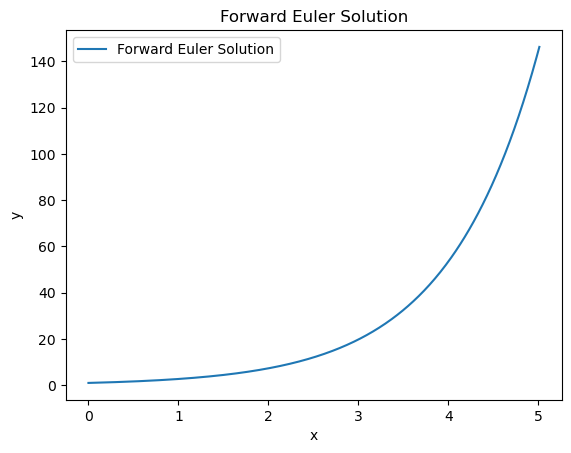

the max error I see in the domain is 146.220500156899
the max error with the default solver is 148.394408736988


In [38]:

from sympy import solve
import matplotlib.pyplot as plt
from sympy import *
def fun(x, y): #dy/dx
    return y
solution = solve_ivp(fun, [0, 5], y0 = [1], method = ForwardEuler, h = 0.01)
plt.plot(solution.t, solution.y[0], label = "Forward Euler Solution")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Forward Euler Solution")
plt.show()

x = symbols('x')
y = Function('y')(x)
ode = Eq(y.diff(x), y)
solution_sympy = dsolve(ode)
solution_sympy = solution_sympy.rhs
Constant = symbols('C1')
y_0 = 1
constant_solution = solve(solution_sympy.subs({y: y_0, x: 0}), Constant)
#print(solution_sympy)
particular_solution = solution_sympy.subs(Constant, constant_solution[0])

y_exact = [particular_solution.subs(x, val) for val in solution.t]
error_euler = np.abs(y_exact - solution.y[0])
max_error_euler = np.max(error_euler)
print("the max error I see in the domain is", max_error_euler)
solution_default = solve_ivp(fun, [0, 5], [1])
y_exact_default = [particular_solution.subs(x, val) for val in solution_default.t]
error_default = np.abs(y_exact_default - solution_default.y[0])
max_error_default = np.max(error_default)
print("the max error with the default solver is", max_error_default)





### Part C (optional challenge)

Use Richardson (see Problem 0) on your Forward Euler solver. How does the error change? You can assume that $m=1$ and derive the formula analytically. What happens if you do Richardson twice?

In [3]:
from sympy import solve
from scipy.integrate import solve_ivp
from euler import ForwardEuler
import numpy as np
def richardson(y1, y2):
    return (2*y2 - y1)
def fun(x, y): #dy/dx
    return y
solution_with_step_h = solve_ivp(fun, [0, 5], [1], method = ForwardEuler, h = 0.01)
solution_with_step_h2 = solve_ivp(fun, [0, 5], [1], method = ForwardEuler, h = 0.01 / 2)
y2_interpolated = np.interp(solution_with_step_h.t, solution_with_step_h2.t, solution_with_step_h2.y[0])
result = richardson(solution_with_step_h.y[0], y2_interpolated)
realResult = [particular_solution.subs(x, val) for val in solution_with_step_h.t]
error_R = np.abs(realResult - result)
max_error_R = np.max(error_R)
print("the max error with Richardson is", max_error_R)

NameError: name 'particular_solution' is not defined

In [ ]:
Twice
If we do Richardson twice, we will solve one more solution which has step size h = 0.01/4
And we will not ony apply Richardson on results from h = 0.01 and h = 0.01/2,
but also do Richardson with h = 0.01/2 and h = 0.01/4
As a result, since we do more work, the result will be more accurate, which means the error is decreasing

## Problem 1 (20 points)

Now that you're warmed up, here are some more simulations.

### Part A (15 points)

In this problem, we'll simulate a planet and moon moving in a 2-dimensional plane.

Newton's law of gravity says that $F_g = Gm_1 m_2 / \|r\|^2$.  The direction of the force is in the direction of the vector $r$.  Let $x(t)$ dentote the position of the planet and $y(t)$ denote the position of the moon, and $r(t) = x(t) - y(t)$ Then
\begin{equation}
x''(t) = -F_g / m_1 \times r / \|r\|\\
y''(t) = F_g / m_2 \times r / \|r\|
\end{equation}
$x$ and $y$ are 2-vectors, so this is a system of 4-second order ODEs.  We can use the following trick to write this as 8 first order ODEs. Let $p(t)$ be the velocity of the planet and $q(t)$ be the velocity of the moon (note that they are vector valued!). So, $p(t) = x'(t)$, and $q(t) = y'(t)$.  Here are the terms for $x$:
\begin{equation}
p_1'(t) = -F_g / m_1 \times r_1(t) / \|r\|\\
p_2'(t) = -F_g / m_1 \times r_2(t) / \|r\|\\
x_1'(t) = p_1(t)\\
x_2'(t) = p_2(t)
\end{equation}
\begin{equation}
q_1'(t) = F_g / m_2 \times r_1(t) / \|r\|\\
q_2'(t) = F_g / m_2 \times r_2(t) / \|r\|\\
y_1'(t) = q_1(t)\\
y_2'(t) = q_2(t)
\end{equation}

We'll model the Earth and moon.  The [Gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant) has value `G=6.67 e-11` (we're dropping units, which are all SI).  The mass of the earth is `m1 = 5.972 e24`, and the mass of the moon is `m2=0.07346 e24`.  The distance from the moon to the earth is `r = 384.4 e6`.  This means the orbital speed of the moon around the earth is about `1.022 e3`.

Use `solve_ivp` to run a simulation of the moon orbiting the earth for `5 e6` seconds (about 2 months).  Use initial conditions $x(0) = 0, p(0) = 0$ for the earth, and $y(0) = (0, 384.4 \times 10^6)$ and $q(0) = (1.022 \times 10^3, 0)$

Plot $x_1(t), x_2(t)$ and $y_1(t), y_2(t)$ in the same plane with different colors (include a legend and title).

---

*Put any answers/discussion here*

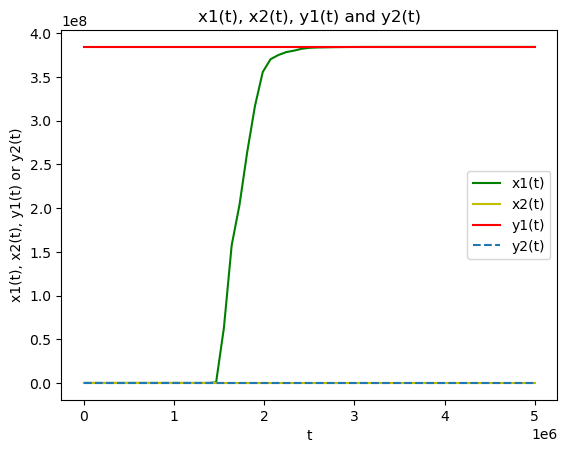

In [17]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
def derivatives(t, Y):
    x, y, dxdt, dydt, x_moon, y_moon, dx_moondt, dy_moondt = Y
    r = np.sqrt((x - x_moon)**2 + (y - y_moon)**2)
    Fg = G * earth_mass * moon_mass / r**3
    dpxdt = (-1) * Fg * (x - x_moon)
    dpydt = (-1) * Fg * (y - y_moon)
    dqxdt = Fg * (x - x_moon) / moon_mass
    dqydt = Fg * (y - y_moon) / moon_mass
    return [dxdt, dydt, dpxdt, dpydt, dx_moondt, dy_moondt, dqxdt, dqydt]

G = 6.67e-11
earth_mass = 5.972e24
moon_mass = 0.07346e24
init_conditions = [0, 0, 0, 0, 384.4e6, 0, 1.022e3, 0]
time_span = [0, 5e6]
solution = solve_ivp(derivatives, time_span, init_conditions)
plt.plot(np.linspace(0, 5e6, 59), solution.y[0], 'g', label = "x1(t)")
plt.plot(np.linspace(0, 5e6, 59), solution.y[1], 'y', label = "x2(t)")
plt.plot(np.linspace(0, 5e6, 59), solution.y[4], 'r', label = "y1(t)")
plt.plot(np.linspace(0, 5e6, 59), solution.y[5], '--', label = "y2(t)")
plt.legend()
plt.title("x1(t), x2(t), y1(t) and y2(t)")
plt.xlabel("t")
plt.ylabel("x1(t), x2(t), y1(t) or y2(t)")
plt.show()

### Part B (5 points)

Now simulate a system with 10 planets, in 10 random locations. The planets should have random masses chosen independently and uniformly from the interval $[0,6 \times 10^{24}]$ and initial locations chosen randomly from the $(8 \times 10^8) \times (8\times 10^8)$ square centered at the origin. The components of each planet's initial velocity should be chosen randomly on $[-5\times 10^{2}, 5 \times 10^{2}].$ Plot the positions of each planet as a function of time.

---

*Your answer here.  You can create some code cells as well*

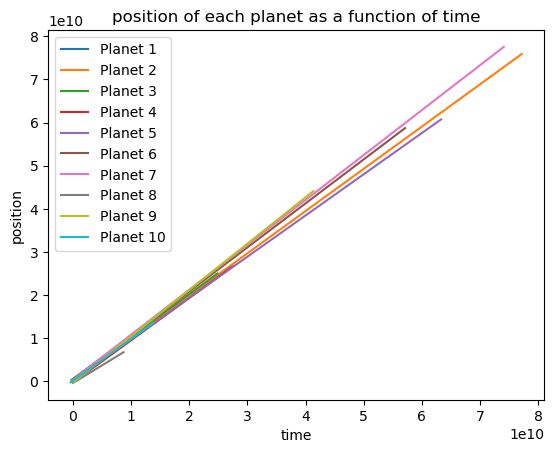

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

masses = np.random.uniform(0, 6e24, 10)
posi = np.random.uniform(-4e8, 4e8, size = (10, 2))
velo = np.random.uniform(-500, 500, size = (10, 2))
initial_conditions = np.concatenate([posi.flatten(), velo.flatten()]).tolist()
def derivatives(t, Y):
    positions = np.array(Y[:2*10]).reshape((10, 2))
    velocities = np.array(Y[2*10:]).reshape((10, 2))
    accelerations = np.zeros((10, 2))
    for i in range(10):
        accel = 0
        for j in range(10):
            if i != j:
                diff = positions[j] - positions[i]
                r = np.sqrt(diff[0]**2 + diff[1]**2)
                #r = positions[j] - positions[i]
                r_mag = np.linalg.norm(diff)
                accel += (6.67e-11 * float(masses[j]) / float(r_mag)**3) *  float(r)
                #accel += (6.67e-11 * float(masses[j])) *  float(r)
        accelerations[i] = accel

    return np.concatenate((velocities.flatten(), accelerations.flatten()))

t_span = [0, 5e6]
#rangeEval = np.linspace(0, 5e6, 10000)
solution = solve_ivp(derivatives, t_span, initial_conditions)

for i in range(10):
    plt.plot(solution.y[2*i], solution.y[2*i+1], label = "Planet {}".format(i+1))

plt.legend()
plt.title("position of each planet as a function of time")
plt.xlabel("time")
plt.ylabel("position")
plt.show()

## Problem 2 (30 points)
In this problem, we will solve some a simple PDE using the "method of lines". In this method, we replace the
$$\partial_t u(t,x) = \Delta u(t,x) $$
PDE by the system of ODEs
$$ \partial_t\boldsymbol{u}(t) = A \boldsymbol{u}(t),$$
where
$$[\boldsymbol{u}(t)]_i=u_i(t) \approx u(t,x_i). $$
The matrix $A$ approximates the differential operator using, e.g. finite differences
$$ \Delta u \to A \boldsymbol{u}.$$

After we semi-discretize in space we are left with a large system of ODEs that we can solve using our favorite method.
 

### Part A (25 points)
In this problem we will solve the heat equation 
\begin{equation}
\begin{cases}
\partial_t u(t,x) = \Delta u(t,x) & x\in [0,1], \;t\in[0,T]\\
u(0,x) = f(x) & x\in [0,1]\\
u(t,0) = a & t \in [0,T]\\
u(t,1) = b & t \in [0,T]\\
\end{cases}
\end{equation}
with the method of lines.

To solve this equation, we discretize the interval $x\in[0,1]$ with $n+2$ points. The end points will be used to enforce boundary conditions and the interior points will be used to compute the right hand side of the PDE. We approximate the Laplacian operator using the second order centered difference formula
$$g''(x) = \frac{g(x+h)-2g(x)+g(x-h)}{h^2}$$
and we integrate in time using the forward Euler method.

Your code for implementing this method should include the following three functions
1. `second_diff`, which computes the second derivative of $u$ at the interior nodes (using the centered difference formula) and returns it as an array with zeros on each end (as the boundary conditions don't change)
2. `forward_time_step`, which uses $u(t_n,x)$ and the forward Euler method to compute $u(t_{n+1},x)$
3. `sim_heat`, which solves the heat equation by setting $u(0,x)=f(x)$ and then calling `forward_time_step` repeatedly to compute $u(T,x)$. This function should accept the following inputes
    * `n` the number of internal nodes 
    * `f` the initial condition
    * `bc` a list containing the left and right boundary conditions $a$ and $b$
    * `dx` the grid spacing, i.e. the distance between x values i.e. $1/(n+1)$
    * `dt` the time step to be used by the forward Euler method
    * `T` the time at which we want the solution $u(T,x)$. Note that in general $T/dt$ will not be an integer, so the last call of `forward_time_step` will have to use a smaller time step than `dt`

Once you have created these functions, solve the heat equation with
\begin{gather}
f(x) = \sin(2\pi x)\\
a = b = 0
\end{gather}
up until time $T=0.02$ using $n=99$ and `dt=0.2*dx**2`. 

To verify the accuracy of your code, compare the output to the exact solution $u(t,x)= \exp(-4\pi^2t)\sin(2\pi x)$. You can do this by summing the sum of squares errors at your $x_i$'s and dividing by $\sqrt{n}$.

You should also include a plot of $u(0,x)$ and $u(T,x)$.

The error is: 1.6676678426167939e-06


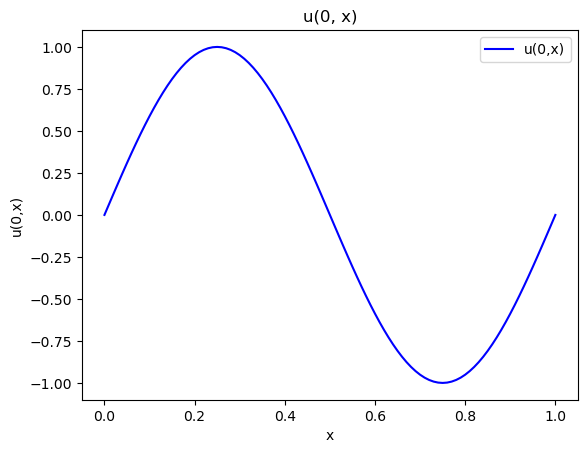

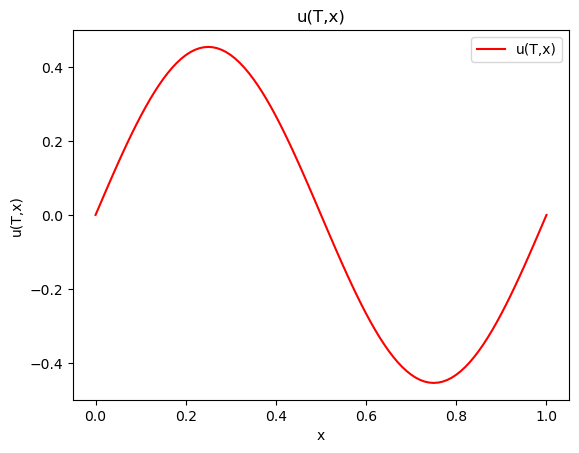

In [33]:
import numpy as np
def second_diff(u, dx):
    secDifu = np.zeros(len(u))
    #print(u[3])
    for i in range(1, len(u) - 1):
        num = (u[i + 1] - 2 * u[i] + u[i - 1]) / dx ** 2
        
#         while type(num) is not np.float64:
#             num = num[0]
        secDifu[i] = num
    return secDifu

def forward_time_step(u, dx, dt):
    secDiff = second_diff(u, dx)
    u_next = u + dt * secDiff
    #u_next = [u + dt * i for i in secDiff]
    return u_next

def sim_heat(n, f, bc, dx, dt, T):
    u = np.zeros(n + 2)
    x = np.linspace(0, 1, n + 2)
    u[1:-1] = f(x[1:-1])
    u[0], u[-1] = bc[0], bc[1]
    t = 0
    #print(u)
    while t < T:
        # Ensure we don't overshoot T
        dt = 0.2 * dx ** 2 
        dt = min(dt, T - t)
        u = forward_time_step(u, dx, dt)
        t += dt
    return u

def f(x):
    return np.sin(2 * np.pi * x)
        
n = 99
dx = 1.0 / (n + 1)
dt = 0.2 * dx ** 2
T = 0.02
#print(len(u_actual))
u_actual = sim_heat(n, f, [0,0], dx, dt, T)
x = np.linspace(0, 1, n+2)

u_exact = lambda t, x: np.exp(-4*np.pi**2*t) * np.sin(2*np.pi*x)
#print(len(u_exact(T, x)))
error = np.sqrt(dx * np.trapz((u_actual - u_exact(T, x))**2, x))
print("The error is:", error)

# Plot the results
plt.plot(x, f(x), 'b', label="u(0,x)")
plt.xlabel("x")
plt.ylabel("u(0,x)")
plt.title("u(0, x)")
plt.legend()
plt.show()

plt.plot(x, u_actual, 'r', label="u(T,x)")
plt.xlabel("x")
plt.ylabel("u(T,x)")
plt.title("u(T,x)")
plt.legend()
plt.show()


## Part B (5 points)
Now solve for $u(T,x)$ using the same parameters as above, except that you should set `dt=0.7*dx**2`. Create a plot of $u(0,x)$ and $u(T,x)$ and compare it to the plot from the previous question. The ratio $dt/dx^2$ is called the CFL (Courant–Friedrichs–Lewy) number and the observation that you will make is an important concept in numerical PDE methods.

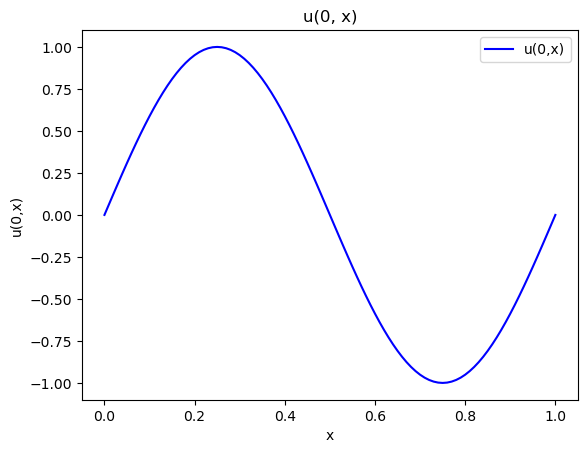

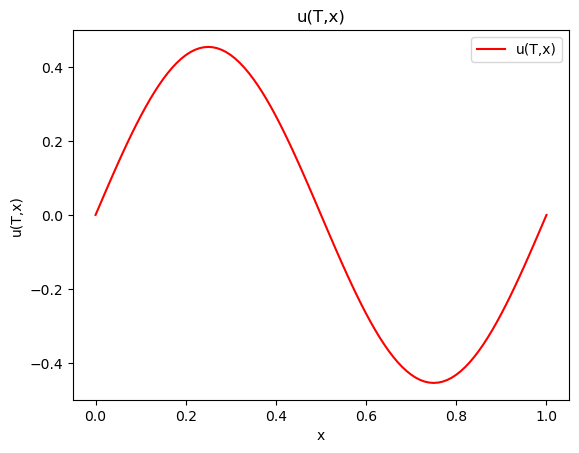

In [32]:

n = 99
dx = 1.0 / (n + 1)
dt = 0.7 * dx ** 2
u_actual = sim_heat(n, f, [0,0], dx, dt, 0.02)
plt.plot(x, f(x), 'b', label="u(0,x)")
plt.xlabel("x")
plt.ylabel("u(0,x)")
plt.title("u(0, x)")
plt.legend()
plt.show()

plt.plot(x, u_actual, 'r', label="u(T,x)")
plt.xlabel("x")
plt.ylabel("u(T,x)")
plt.title("u(T,x)")
plt.legend()
plt.show()

## Part C (optional, 5 bonus points)
The CFL condition that $dt/dx^2<0.5$ is prohibitively restrictive. To get around this, we can use so-called implicit time stepping schemes, which are far more stable, though computationally costly. The simplest of these schemes is the backwards Euler method:
$$ y(t_{n+1}) = y(t_n) + dt y'(t_{n+1})$$
(Note that $y'$ is now evaluated at a future time.) When solving a linear system of ODEs
$$ y'= A y$$
the backwards Euler method requires us to solve the linear system
$$ (I - dt A)y(t_{n+1}) = y(t_{n}). $$

In this problem you should modify your existing code to solve the heat equation using this implicit time stepping scheme. In order to do this efficiently, you should construct and store a Cholesky factorization of the matrix $I-dt A$.

With this new code, repeat the experiment from part B. Do you run into the same stability problem?

Further, with this method, are you able to make $dt$ a comparable size to $dx$?

## Feedback

If you would like share how long it took you to complete this assignment, it will help adjust the difficulty for future assignments.  You're welcome to share additional feedback as well.